## CUPED

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import warnings

from statsmodels.stats.proportion import proportion_confint

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error

from catboost import CatBoostRegressor
from statsmodels.formula.api import ols

sns.set(palette='Set2', style='whitegrid', font_scale=1.2)

pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

---

Провалидируем и сравним методы CUPED через линейную регрессию:

Существует несколько методов обобщения CUPED с помощью линейной регрессии:
* стандартный двухшаговый,
* комбинированный одношаговый,
* комбинированный двухшаговый.

Провалидируем эти методы по величине вероятности ошибки I рода и сравним их по мощности. В качестве данных рассмотрим
* простые искусственные данные,
* искусственные данные с нелинейной зависимостью от ковариаты и гетероскедастичностью.

In [ ]:
def generate_train_test_sample(
    sample_size=1000, shape=5, scale=1000, scale_factor=0.3
):
    '''
    Генерация всей совокупности объектов

    sample_size -- размер выборки
    shape -- параметр формы гамма-распределения
    scale -- масштаб данных
    scale_factor -- доля увеличения дисперсии на экспериментальном периоде

    Возвращает данные за предэкспериментальный и экспериментальный периоды.
    '''

    base = np.random.gamma(shape=shape, scale=scale, size=sample_size)

    data = pd.DataFrame()

    data['pilot'] = base + np.random.normal(
        size=sample_size,
        scale=base.std() * scale_factor
    )
    data['prepilot'] = base + np.random.normal(
        size=sample_size,
        scale=base.std() * scale_factor
    )

    return data


def generate_two_independent_samples(
    sample_size=1000, shape=5, scale=1000, scale_factor=0.3
):
    '''
    Генерация двух независимых выборок

    sample_size -- размер каждой выборки
    shape -- параметр формы гамма-распределения
    scale -- масштаб данных
    scale_factor -- доля увеличения дисперсии на экспериментальном периоде

    Возвращает данные за предэкспериментальный и экспериментальный периоды.
    '''

    return [
        generate_train_test_sample(
            sample_size=sample_size, shape=shape, scale=scale, scale_factor=scale_factor
        )
        for _ in range(2)
    ]

def cuped_transform(
    x_data, y_data, target_name='pilot', covariate_name='prepilot', return_theta=False
):
    '''
    Выполняет CUPED-преобразование.

    :param x_data: данные тестовой группы
    :param y_data: данные контрольной группы
    :param target_name: имя столбца с целевой метрикой
    :param covariate_name: имя столбца-ковариаты
    :param return_theta: возвращать ли значение theta
    :return: таблицы с добавленными столбцами и theta
    '''

    theta = (
        np.cov(x_data[covariate_name], x_data[target_name])[0, 1] \
        + np.cov(y_data[covariate_name], y_data[target_name])[0, 1]
    ) / (
        x_data[covariate_name].var(ddof=0) + y_data[covariate_name].var(ddof=0)
    )

    x_data['cuped'] = x_data[target_name] - theta*x_data[covariate_name]
    y_data['cuped'] = y_data[target_name] - theta*y_data[covariate_name]

    if return_theta:
        return x_data, y_data, theta
    else:
        return x_data, y_data

def cuped_ttest(x_data, y_data, target_name='pilot', covariate_name='prepilot', alpha=0.05):
    '''
    Абсолютный t-test.

    :param x_data: выборка вместе с информацией о cuped-преобразовании
    :param y_data: выборка вместе с информацией о cuped-преобразовании
    :param target_name: имя столбца с целевой метрикой
    :param covariate_name: имя столбца-ковариаты
    :param alpha: теор вероятность ошибки первого рода
    :return: статистика критерия, p-value
    '''

    x_data, y_data = cuped_transform(x_data, y_data, target_name=target_name, covariate_name=covariate_name)
    return sps.ttest_ind(x_data['cuped'], y_data['cuped'])

def estimate_reject_prob(n_rejects, n_iter):
    '''
    Оценка вероятности отвержения критерия и ее дов. интервала.
    Используется для оценки вероятности ошибки первого рода и мощности

    Аргументы:
    n_rejects -- количество отвержений H_0 в эксперименте
    n_iter -- количество экспериментов

    Возвращает:
    prob_reject -- оценка вероятности отвержения критерия
    left_bound, right_bound -- границы соотв. дов. интервала
    '''

    prob_reject = n_rejects / n_iter
    left_bound, right_bound = proportion_confint(n_rejects, n_iter, method='wilson')

    return prob_reject, left_bound, right_bound


def visualization(prob_reject, left_bound, right_bound,
                  show_pvals=False, pvals=None, alpha=0.05, figsize=(7, 2), title=None):
    '''
    Отрисовка интервала для вероятности отвержения критерия
    и гистограммы p-value (опционально)
    prob_reject -- оценка вероятности отвержения
    left_bound, right_bound -- границы доверительного интервала
    alpha -- теор вероятность ошибки первого рода
    show_pvals -- показывать ли распределение p-value
    pvals -- массив из p-value
    figsize -- размер фигуры matplotlib
    '''

    # построение гистограммы p-value (опционально)
    if show_pvals:
        with sns.axes_style("whitegrid"):
            plt.figure(figsize=figsize)
            plt.subplot(1, 2, 1)
            plt.hist(pvals, bins=np.linspace(0, 1, 21), alpha=0.7,
                    weights=np.ones(len(pvals)) / len(pvals))
            plt.title('Распределение p-value')

    # отрисовка интервала для вероятности отвержения критерия
    with sns.axes_style("whitegrid"):
        if show_pvals:
            plt.subplot(1, 2, 2)
        else:
            plt.figure(figsize=figsize)
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(alpha, -1, 1, color='red', lw=5, linestyle='--', alpha=0.6)
        plt.fill_between(
            [left_bound, right_bound], [0.15]*2, [-0.15]*2,
            color='green', alpha=0.6
        )
        plt.scatter(prob_reject, 0, s=300, marker='*', color='red')
        plt.xlim((min(alpha, left_bound)-1e-3, max(alpha, right_bound)+1e-3))
        plt.title(
            f'Доля отвержений = {100*prob_reject:.2f}%, '
            f'интервал ({100*left_bound:.2f}%, {100*right_bound:.2f}%)'
        )
        plt.suptitle(title)
        plt.ylim((-0.5, 0.5))
        plt.yticks([])
        plt.tight_layout()
        plt.show()


def draw_power(powers, left_powers, right_powers, effects_list=np.linspace(0, 0.1, 11), label=None,
               title='Графики мощности', new_figure=False):
    '''
    Построение и отрисовка графика мощности критерия.

    Аргументы:
    powers -- оценка мощности
    left_powers, right_powers -- границы соотв. дов. интервала
    effects -- сетка эффектов
    real_alpha -- оценка реальной мощности
    left_alpha, right_alpha -- границы соотв. дов. интервала
    title -- заголовок графика
    '''

    if new_figure:
        plt.figure(figsize=(10, 4))

    plt.plot(effects_list, powers, label=label, lw=3)
    plt.fill_between(effects_list, left_powers, right_powers, alpha=0.3)

    if new_figure:
        plt.hlines(0.8, effects_list[0], effects_list[-1], color='black', alpha=0.5,
                   label='Мощность 0.8 (пересечение — MDE)')
    plt.legend()
    plt.xlabel('Размер относительного эффекта')
    plt.ylabel('Мощность')
    plt.title(title)

def add_effect(x, effect, target_name='pilot', relative_effect=True):
    '''
    Функция искусственного добавления эффекта в тестовую выборку

    Аргументы:
    x -- выборка
    effect -- добавляемый эффект
    target_name -- имя столбца с целевой метрикой
    relative_effect -- является ли эффект относительным или абсолютным

    Возвращает:
    x -- выборка с добавленным эффектом
    '''

    x_copy = x.copy()
    if relative_effect:
        x_copy[target_name] *= (1 + effect)
    else:
        x_copy[target_name] += effect

    return x_copy

def run_experiments(
    test, generate_samples,
    n_iter=10000, sample_size=1000, effect=0, relative_effect=True,
    alpha=0.05, target_name='pilot', draw=False, title=None, show_pvals=True,
):
    '''
    Проведение серии AA-тестов на искусственных выборках.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    effect -- размер добавляемого эффекта (для оценки мощности)
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя столбца с целевой метрикой
    '''

    n_rejects = 0  # количество отвержений H_0
    pvals = []  # значения p-value

    # Проведение экспериментов
    for _ in tqdm(range(n_iter), leave=False):
        # Генерируем выборки
        x_data, y_data = generate_samples(size=sample_size)

        # Добавляем эффект, если хотим оценить мощность
        x_data = add_effect(x_data, effect, target_name=target_name, relative_effect=relative_effect)

        # Применяем критерий
        pvals.append(test(x_data, y_data)[1])
        n_rejects += (pvals[-1] < alpha)

    # Оценка вероятности отвержения
    prob_reject, left_bound, right_bound = estimate_reject_prob(n_rejects, n_iter)

    # Визуализация
    if draw:
        figsize = (14, 3) if show_pvals else (5, 2)
        visualization(
            prob_reject, left_bound, right_bound, show_pvals,
            pvals, alpha, figsize, title
        )

    return prob_reject, (left_bound, right_bound)


def estimate_power(
    test, generate_samples,
    n_iter=10000, sample_size=1000, effects_list=np.linspace(0, 0.1, 11), relative_effect=True,
    alpha=0.05, target_name='pilot'
):
    '''
    Проведение серии тестов на искусственных выборках для оценки мощности.

    Аргументы:
    test -- статистический критерий
    generate_samples -- функции для семплирования выборок
    n_iter -- количество итераций
    sample_size -- размер выборок
    effects_list -- список добавляемых эффектов
    relative_effect -- является ли эффект относительным или абсолютным
    alpha -- теор вероятность ошибки первого рода
    target_name -- имя столбца с целевой метрикой
    '''

    powers = np.zeros(len(effects_list))
    left_bounds = np.zeros(len(effects_list))
    right_bounds = np.zeros(len(effects_list))

    for i, effect in tqdm(enumerate(effects_list), leave=False):
        powers[i], (left_bounds[i], right_bounds[i]) = run_experiments(
            test, generate_samples,
            n_iter=n_iter, sample_size=sample_size, effect=effect, relative_effect=relative_effect,
            alpha=alpha, target_name=target_name, draw=False,
        )

    return powers, left_bounds, right_bounds



Напишем функции для ttesta с методами обобщения CUPED с помощью линейной регрессии:

С помощью обычной линейной регресии (одношаговый метод):

In [ ]:
def regression_ttest(x_data, y_data, cuped=True, sample_name='pilot',
                     treatment_name='treatment', covariate_names=[]):
    '''
    T-test с CUPED/без CUPED, реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат

    Возвращает:
    stat -- статистика критерия
    pvalue -- p-value критерия
    left_bound, right_bound -- границы дов. интервала
    '''

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])

    # определяем имена фичей, на которых будем обучать модель
    if cuped:
        feature_names = [treatment_name] + list(covariate_names)
    else:
        feature_names = [treatment_name]

    # обучаем модель
    model = ols(f'{sample_name} ~ '+ '+'.join(feature_names), data=data).fit(cov_type='HC3')
    # забираем таблицу с результатами
    summary = model.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, 'z']
    pvalue = summary.loc[treatment_name, 'P>|z|']
    left_bound = summary.loc[treatment_name, '[0.025']
    right_bound = summary.loc[treatment_name, '0.975]']
    return stat, pvalue, left_bound, right_bound

Реализуем линейную модель, в точности совпадающую со стандартным CUPED на основе regression_ttest:

In [ ]:
def regression_ttest_as_CUPED(x_data, y_data, cuped=True, sample_name='pilot',
                     treatment_name='treatment', covariate_names=[]):
    '''
    T-test с CUPED/без CUPED, реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат

    Возвращает:
    stat -- статистика критерия
    pvalue -- p-value критерия
    left_bound, right_bound -- границы дов. интервала
    '''

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])

    # определяем имена фичей, на которых будем обучать модель
    # if cuped:
    #     feature_names = [treatment_name] + list(covariate_names)
    # else:
    #     feature_names = [treatment_name]

    # обучаем модель 1 (только на ковариатах)
    model_1 = ols(f'{sample_name} ~ '+ '+'.join(covariate_names), data=data).fit(cov_type='HC3')
    # получаем коэффициент при ковариате в первой линейной модели
    theta_cov = model_1.params[covariate_names[0]]
    # вычитаем произведение полученного коэффициента при ковариате на ковариату из значений y_i
    data['without_covariat'] = data[sample_name] - theta_cov * data[covariate_names[0]]
    # обучаем модель 2
    model_2 = ols(f'without_covariat ~ {treatment_name}', data=data).fit(cov_type='HC3')
    # забираем таблицу с результатами
    summary = model_2.summary2().tables[1]
    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, 'z']
    pvalue = summary.loc[treatment_name, 'P>|z|']
    left_bound = summary.loc[treatment_name, '[0.025']
    right_bound = summary.loc[treatment_name, '0.975]']
    return stat, pvalue, left_bound, right_bound

Реализуем двухшаговую линейную регрессию на основе regression_ttest:

In [ ]:
def regression_ttest_double_step(x_data, y_data, cuped=True, sample_name='pilot',
                     treatment_name='treatment', covariate_names=[]):
    '''
    T-test с CUPED/без CUPED, реализованный через линейную регрессию

    Аргументы:
    x, y -- выборки одинакового размера
    :param cuped: применять ли cuped
    :param sample_name: имя столбца с целевым признаком
    :param covariate_names: массив имен столбцов-ковариат

    Возвращает:
    stat -- статистика критерия
    pvalue -- p-value критерия
    left_bound, right_bound -- границы дов. интервала
    '''

    # добавляем столбец с индикатором тестовой группы
    x_data[treatment_name] = 1
    y_data[treatment_name] = 0
    # объединяем тест и контроль в один датасет
    data = pd.concat([x_data, y_data])

    # определяем имена фичей, на которых будем обучать модель
    if cuped:
        feature_names = [treatment_name] + list(covariate_names)
    else:
        feature_names = [treatment_name]

    # обучаем 1-ю модель
    model_1 = ols(f'{sample_name} ~ ' + '+'.join(feature_names), data=data).fit(cov_type='HC3')
    # получаем коэффициент при ковариате:
    theta_cov = model_1.params[covariate_names[0]]
    # вычитаем произведение полученного коэффициента при ковариате на ковариату из значений y_i
    data['without_covariat'] = data[sample_name] - theta_cov * data[covariate_names[0]]

    # обучаем модель 2
    model_2 = ols(f'without_covariat ~ {treatment_name}', data=data).fit(cov_type='HC3')

    # забираем таблицу с результатами
    summary = model_1.summary2().tables[1]

    # берем из таблицы нужные поля
    stat = summary.loc[treatment_name, 'z']
    pvalue = summary.loc[treatment_name, 'P>|z|']
    left_bound = summary.loc[treatment_name, '[0.025']
    right_bound = summary.loc[treatment_name, '0.975]']
    return stat, pvalue, left_bound, right_bound

## Рассмотрим простые искусственные данные из ноутбука с занятия:

Зафиксируем параметры из семинарского ноутбука:

In [ ]:
total_size = 10_000  # Общее количество объектов в данных
sample_size = 200  # Размер выборки
# n_iter = 10_000  # Количество итераций семплирования
n_iter = 500
alpha = 0.05  # теор вероятность ошибки первого рода

lw = 5  # Толщина линий на графиках

In [ ]:
x_data, y_data = generate_two_independent_samples(sample_size=sample_size)

Провалидируем данные:

  0%|          | 0/500 [00:00<?, ?it/s]

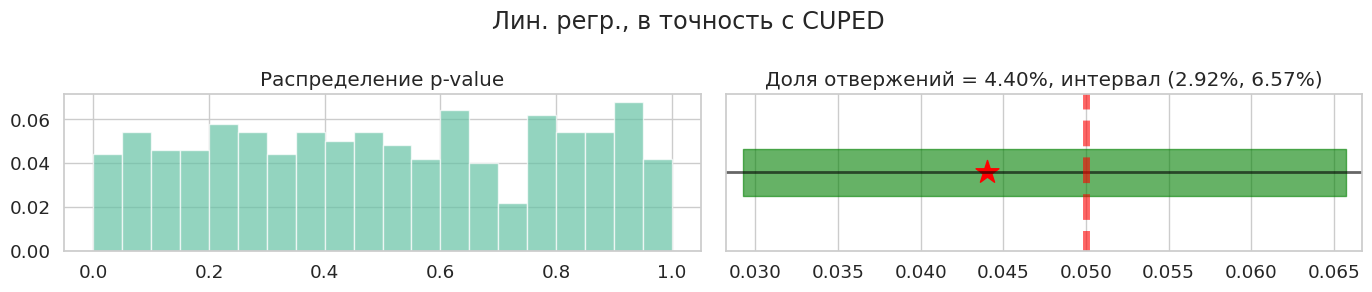

  0%|          | 0/500 [00:00<?, ?it/s]

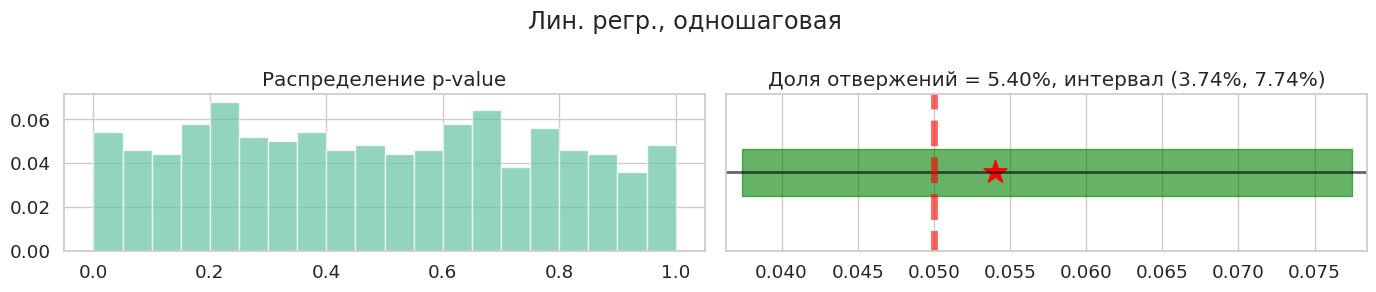

  0%|          | 0/500 [00:00<?, ?it/s]

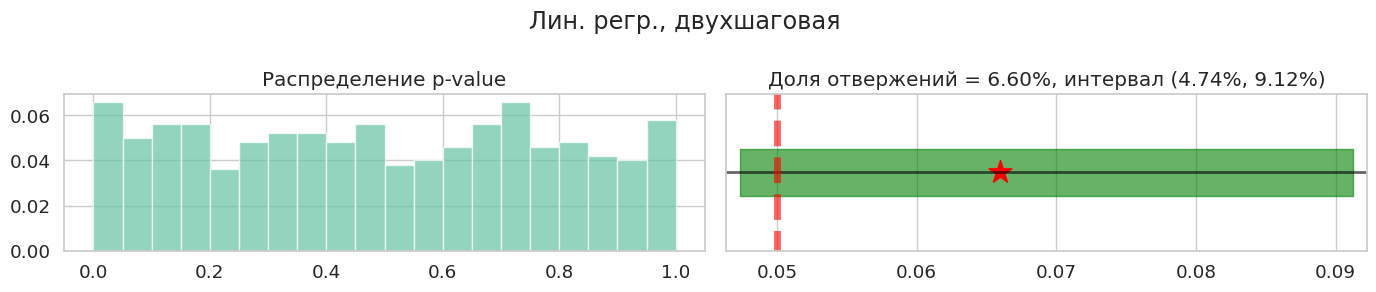

  0%|          | 0/500 [00:00<?, ?it/s]

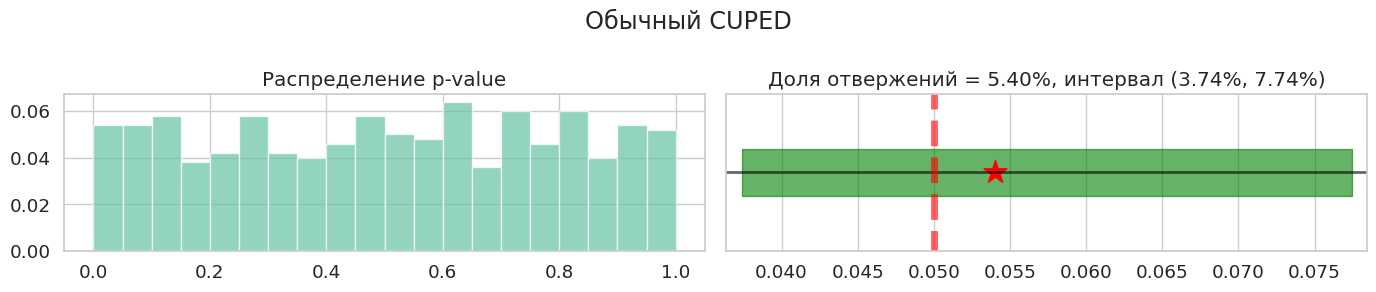

  0%|          | 0/500 [00:00<?, ?it/s]

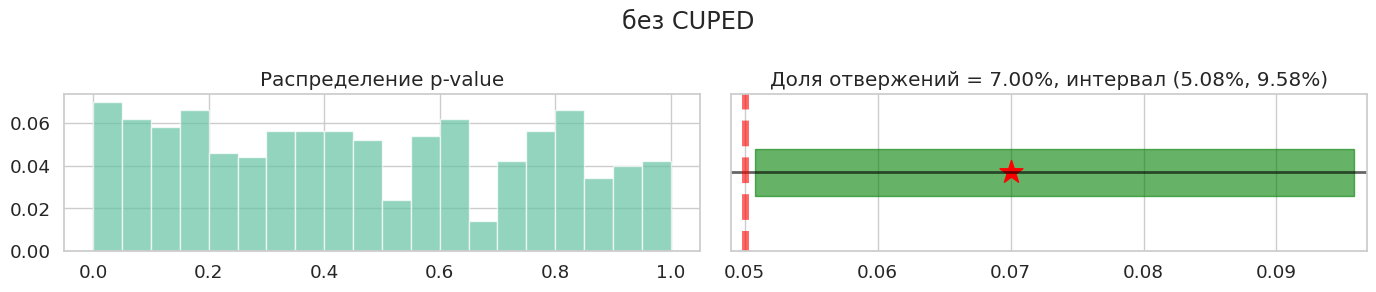

In [ ]:
test_list = [
   lambda x, y:  regression_ttest_as_CUPED(x, y, covariate_names=['prepilot']),
   lambda x, y:  regression_ttest(x, y, covariate_names=['prepilot']),
   lambda x, y:  regression_ttest_double_step(x, y, covariate_names=['prepilot']),
   cuped_ttest,
   lambda x, y: sps.ttest_ind(x['pilot'], y['pilot']),
]

title_list = [
    'Лин. регр., в точность с CUPED',
    'Лин. регр., одношаговая ',
    'Лин. регр., двухшаговая ',
    'Обычный CUPED',
    'без CUPED'
]

for test, title in zip(test_list, title_list):
    run_experiments(
        test=test,
        generate_samples = lambda size: generate_two_independent_samples(sample_size=size),
        sample_size=sample_size,
        n_iter=n_iter,
        draw=True,
        title=title,
    )

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

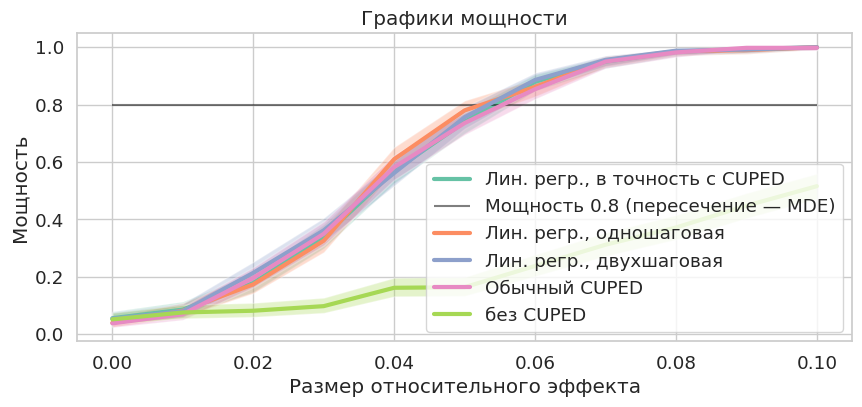

In [ ]:
for i, (test, title) in enumerate(zip(test_list, title_list)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples = lambda size: generate_two_independent_samples(sample_size=size),
        sample_size=sample_size,
        n_iter=n_iter,
    )

    draw_power(powers, left_bounds, right_bounds, label=title, new_figure=(i==0))

## Искусственные данные с нелинейной зависимостью от ковариаты и гетероскедастичностью.

In [ ]:
def generate_train_test_sample_nonlinear(
    sample_size=1000, shape=5, scale=1000, scale_factor=0.3
):
    '''
    Генерация искусственных данных с нелинейной зависимостью и гетероскедастичностью

    sample_size -- размер выборки
    shape -- параметр формы гамма-распределения
    scale -- масштаб данных
    scale_factor -- доля увеличения дисперсии на экспериментальном периоде

    Возвращает данные за предэкспериментальный и экспериментальный периоды.
    '''

    # Генерация базовых данных
    x = np.random.gamma(shape=shape, scale=scale, size=sample_size)

    # Нелинейная зависимость с добавлением гетероскедастичности
    noise_pilot = np.random.normal(size=sample_size,
                                   scale=(0.011 * x + scale_factor))  # гетероскедастичность
    noise_prepilot = np.random.normal(size=sample_size,
                                       scale=(0.01 * x + scale_factor))

    data = pd.DataFrame()

    data['pilot'] = x*x + noise_pilot  # Нелинейная зависимость
    data['prepilot'] = x + noise_prepilot

    return data


def generate_two_independent_samples_nonlinear(
    sample_size=1000, shape=5, scale=1000, scale_factor=0.3
):
    '''
    Генерация двух независимых выборок с нелинейной зависимостью

    sample_size -- размер каждой выборки
    shape -- параметр формы гамма-распределения
    scale -- масштаб данных
    scale_factor -- доля увеличения дисперсии на экспериментальном периоде

    Возвращает данные за предэкспериментальный и экспериментальный периоды.
    '''

    return [
        generate_train_test_sample_nonlinear(
            sample_size=sample_size, shape=shape, scale=scale, scale_factor=scale_factor
        )
        for _ in range(2)
    ]


In [ ]:
total_size = 10_000  # Общее количество объектов в данных
sample_size = 200  # Размер выборки
# n_iter = 10_000  # Количество итераций семплирования
n_iter = 500
alpha = 0.05  # теор вероятность ошибки первого рода

lw = 5  # Толщина линий на графиках

In [ ]:
x_data, y_data = generate_two_independent_samples_nonlinear(sample_size=sample_size)

  0%|          | 0/500 [00:00<?, ?it/s]

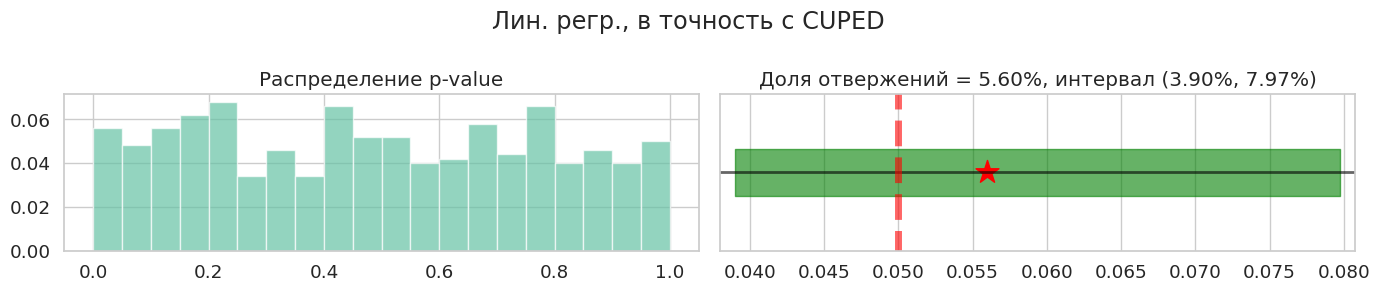

  0%|          | 0/500 [00:00<?, ?it/s]

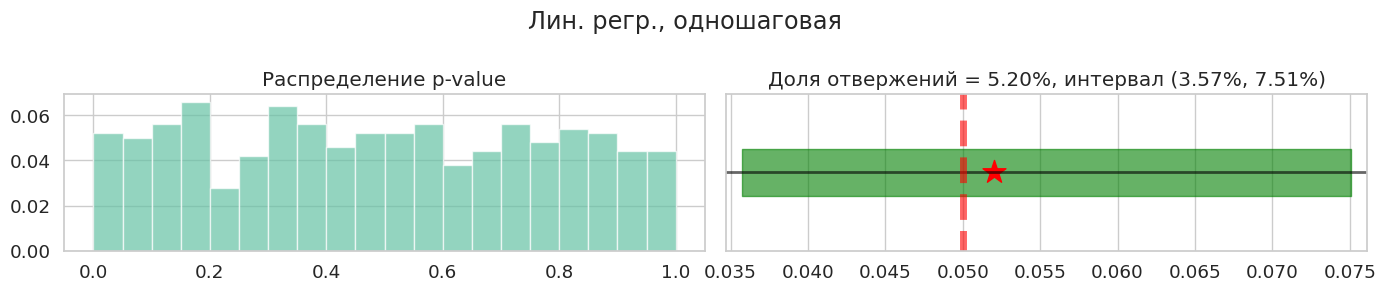

  0%|          | 0/500 [00:00<?, ?it/s]

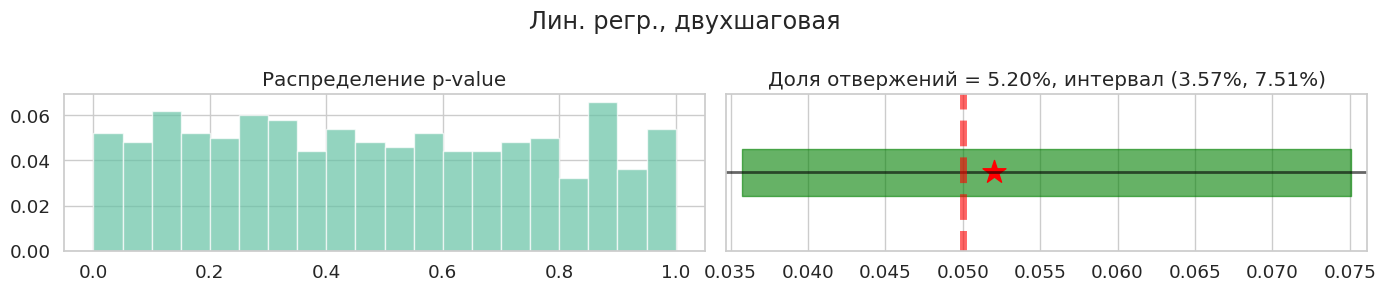

  0%|          | 0/500 [00:00<?, ?it/s]

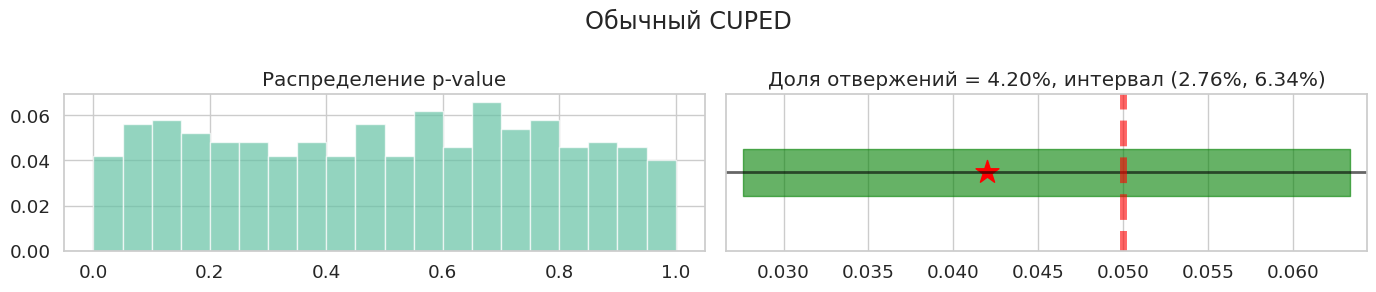

  0%|          | 0/500 [00:00<?, ?it/s]

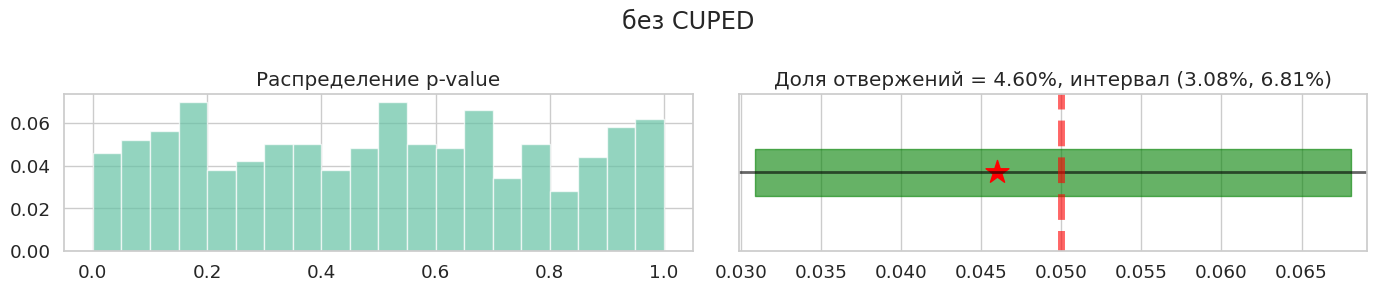

In [ ]:
test_list = [
   lambda x, y:  regression_ttest_as_CUPED(x, y, covariate_names=['prepilot']),
   lambda x, y:  regression_ttest(x, y, covariate_names=['prepilot']),
   lambda x, y:  regression_ttest_double_step(x, y, covariate_names=['prepilot']),
   cuped_ttest,
   lambda x, y: sps.ttest_ind(x['pilot'], y['pilot']),
]

title_list = [
    'Лин. регр., в точность с CUPED',
    'Лин. регр., одношаговая ',
    'Лин. регр., двухшаговая ',
    'Обычный CUPED',
    'без CUPED'
]

for test, title in zip(test_list, title_list):
    run_experiments(
        test=test,
        generate_samples = lambda size: generate_two_independent_samples_nonlinear(sample_size=size),
        sample_size=sample_size,
        n_iter=n_iter,
        draw=True,
        title=title,
    )

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

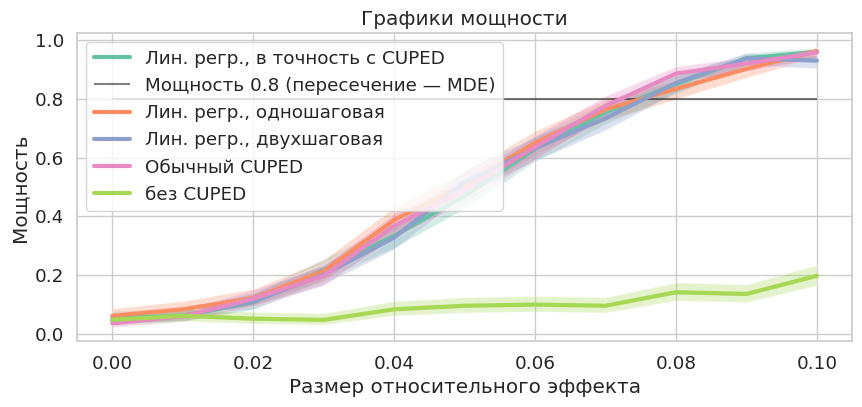

In [ ]:
for i, (test, title) in enumerate(zip(test_list, title_list)):
    powers, left_bounds, right_bounds = estimate_power(
        test=test,
        generate_samples = lambda size: generate_two_independent_samples_nonlinear(sample_size=size),
        sample_size=sample_size,
        n_iter=n_iter,
    )

    draw_power(powers, left_bounds, right_bounds, label=title, new_figure=(i==0))

__**Вывод:**__
Были реализованы и провалидированы методы CUPED через линейную регрессию:
* Все методы (с CUPED) контролируют уровень значимости (5% лежит в доверительном интервале) в обоих случаях: с искусственными данными из ноутбука и искусственные с нелинейностью и гетероскедостичностью
* Мощность методов с CUPED через линейную регрессию значительно выше чем ttest-а без CUPED
* При гетероскедастичности и нелинейности данных методы имеют мощность меньше чем при линейной зависимости (при относительном эффекте 0.06 при данных из ноутбука мощность выше MDE = 0.8, а при гетероскедастичности и нелинейности меньше MDE = 0.8)
